# Pleasant Lake Example
This example is a simplified version of the Pleasant Lake model published by Fienen et al (2021). The goal of the Pleasant Lake model, part of the Central Sands Lake Study, was to address connections between groundwater abstraction and ecological function of a lake in central Wisconsin, USA (WDNR 2021; Figure 1). This required modeling at multiple scales. Fine discretization was needed near the lake for accurate simulation of water levels and groundwater-lake flux. A large model domain was also needed, to simulate farfield water-use activity (chiefly irrigated agriculture) in order to delineate a limit of connection, as well as to incorporate distant hydrologic boundaries. Adopting a fine enough discretization for the lake detail throughout the farfield would have resulted in a model with more cells than could be practically managed. To mitigate this, three models were combined: a large regional model built with MODFLOW-NWT (Niswonger et al. 2011), an intermediate MODFLOW 6 model inset within the regional model to simulate the irrigated agriculture area, and a refined MODFLOW 6 inset model (nested within the intermediate model) to simulate the lake. Regional groundwater flow and the effects of distant boundaries were simulated with the MODFLOW-NWT model, which was coupled sequentially (one-way) to the MODFLOW 6 models through time-varying specified head boundaries along the intermediate MODFLOW 6 model perimeter. The two MODFLOW 6 models were coupled dynamically (both ways) within the groundwater flow solution, allowing for feedback between the models. Estimates of groundwater recharge for the MODFLOW models were provided by a soil water balance code (SWB; Westenbroek et al 2018) simulation that could consider alternative assumptions of climate and land use. Net infiltration estimates from the SWB model were conveyed to the Recharge Packages in the MODFLOW models using the NetCDF functionality in Modflow-setup. 

<img src="https://github.com/aleaf/modflow-setup/blob/develop/docs/source/_static/fig1_pleasant_lake_model.jpg?raw=true" align="center">

**Figure 1**: The full Pleasant Lake model domain with location map, showing the relationship between the regional, intermediate and LGR inset models, as well as the irrigation wells considered.





Most details of the Fienen et al (2021) model are included here, but to reduce file sizes and execution time, a smaller Modflow-6 simulation domain is used. The smaller domain is for illustration purposes only, and is not intended to be adequate for representing pumping impacts or providing a sufficient distance to the perimeter boundaries.


* **[View the configuration file(s)](https://aleaf.github.io/modflow-setup/latest/config-file-gallery.html#pleasant-lake-test-case)** 
* **[Run this example](https://mybinder.org/v2/gh/aleaf/modflow-setup/develop?urlpath=lab/tree/examples)  on  [Binder](https://mybinder.org/)**

#### Model details
* MODFLOW-6 simulation with a dynamically linked parent model and local grid refinement (LGR) inset model
* LGR parent model is itself a Telescopic Mesh Refinment (TMR) inset from a regional MODFLOW-NWT model
* Layer 1 in the regional model is subdivided evenly into two layers in the LGR models (``botm: from_parent: 0: -0.5``). The other layers are mapped explicitly between the TMR parent and LGR models.
* starting heads for the LGR parent models were resampled from the regional model binary output
* rch, npf, sto, and wel input copied from the regional model
* SFR package constructed from an NHDPlus v2 dataset (path to NHDPlus files in the same structure as the `downloads from the NHDPlus website`_)
* head observations from csv files with different column names
* LGR inset extent based on a buffer distance around a feature of interest
* LGR inset dis, ic, npf, sto and rch packages copied from LGR parent
* Lake package created from polygon features, bathymetry raster, stage-area-volume file and climate data from `PRISM`_.
* Lake package observations are set up automatically (output file for each lake)

In [1]:
%%capture
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import patheffects
#import matplotlib.patheffects as PathEffects
import flopy
import flopy.utils.binaryfile as bf
from mfsetup import MF6model
from mfsetup.discretization import cellids_to_kij
from gisutils import df2shp
import mfexport
from mfexport.utils import get_water_table



wd = os.getcwd()

### Just make a model grid
Oftentimes at the start of a modeling project, we want to quickly test different grid resolutions and extents before attempting to build the model. We can do this with Modflow-setup by creating a model instance and then running the ``setup_grid()`` method. A model grid instance is created from the ``setup_grid:`` block in the configuration file. 

Note: ``%%capture`` in the block below is just to suppress printing of ``stdout`` for display of this notebook in the modflow-setup documentation.

In [2]:
%%capture
m = MF6model(cfg='pleasant_lgr_parent.yml')
m.setup_grid()

Since this model has local-grid refinement, it actually consists of two models: a parent built from ``pleasant_lgr_parent.yml``, and an inset built from ``pleasant_lgr_inset.yml``, which is referenced within ``pleasant_lgr_parent.yml``. The two sub-models are connected and solved simulataneously within the same MODFLOW 6 simulation. A model grid is made for each sub-model. The model grids are instances of the ``MFsetupGrid`` grid class, a subclass of the Flopy ``StructuredGrid`` class with some added functionality.

In [3]:
m.modelgrid

5 layer(s), 25 row(s), 25 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553000.0; yll: 388000.0; rotation: 0.0
Bounds: (553000.0, 558000.0, 388000.0, 393000.0)

In [4]:
m.inset['plsnt_lgr_inset'].modelgrid

70 row(s), 80 column(s)
delr: [40.00...40.00] meters
delc: [40.00...40.00] meters
CRS: EPSG:3070
length units: meters
xll: 554200.0; yll: 389000.0; rotation: 0.0
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)

#### Working directory gottcha
Currently, to facilitate working with external files in Flopy, **Modflow-setup changes the working directory to the model workspace**. In the context of a flat script that only builds the model, this is fine, but in a notebook or other workflows, this can potentially cause confusion.

In [5]:
os.getcwd()

'/Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr'

### Write shapefiles of the inset and parent modelgrids
A shapefile of the grid bounding box is written by default on creation of the model grid, to the location specified by ``output_files: grid_file:`` in the ``setup_grid:`` block (default is ``<model workspace>/postproc/shps/``). A shapefile of the grid cells as polygon features can be written as below:

In [6]:
m.modelgrid.write_shapefile('postproc/shps/plsnt_lgr_parent_grid.shp')
m.inset['plsnt_lgr_inset'].modelgrid.write_shapefile('postproc/shps/plsnt_lgr_inset_grid.shp')

creating shapely Polygons of grid cells...
finished in 0.09s

writing postproc/shps/plsnt_lgr_parent_grid.shp... Done
creating shapely Polygons of grid cells...
finished in 0.07s

writing postproc/shps/plsnt_lgr_inset_grid.shp... Done


##### Change the working directory back to the notebook location

In [7]:
os.chdir(wd)

### Build the whole model

In [8]:
m = MF6model.setup_from_yaml('pleasant_lgr_parent.yml')

loading configuration file pleasant_lgr_parent.yml...

Setting up plsnt_lgr_parent model from configuration in pleasant_lgr_parent.yml
loading parent model /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant.nam...
finished in 0.15s


validating configuration...
DIS package
done with validation.

setting up model grid...
wrote /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/plsnt_lgr_parent_grid.json
writing /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps/plsnt_lgr_parent_bbox.shp... Done
finished in 0.02s

loading configuration file /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr_inset.yml...

Setting up DIS package...
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/dem40m.tif...
finished in 0.02s
wrote ./external/plsnt_lgr_parent_top.dat, took 0.00s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/sour

creating shapely Polygons of grid cells...
finished in 0.01s

wrote /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/tables/boundary_cells.shp
perimeter cells took 0.17s

Calculating 3D interpolation weights...
finished in 0.30s


getting perimeter heads...
for stress period 0, took 0.01s
for stress period 1, took 0.00s
for stress period 2, took 0.00s
for stress period 3, took 0.00s
for stress period 4, took 0.00s
for stress period 5, took 0.00s
for stress period 6, took 0.00s
for stress period 7, took 0.00s
for stress period 8, took 0.00s
for stress period 9, took 0.00s
for stress period 10, took 0.00s
for stress period 11, took 0.00s
for stress period 12, took 0.01s
getting perimeter heads took 0.07s

finished in 0.74s


Setting up SFR package...

loading NHDPlus v2 hydrography data...
for basins:
/Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/

finished in 0.14s
caching data in /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/all_lakes.shp...
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/pleasant_bathymetry.tif...
finished in 0.14s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/pleasant_bathymetry.tif...
finished in 0.13s
loading original-arrays/plsnt_lgr_inset_top.dat.original, shape=(70, 80), loading original-arrays/plsnt_lgr_inset_top.dat.original, shape=(70, 80), took 0.01s
computing cell thicknesses...
finished in 0.16s

wrote ./external/plsnt_lgr_inset_top.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_botm_000.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_botm_001.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_botm_002.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_botm_003.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_botm_004.dat, took 0.00s
wrote ./extern

plsnt_lgr_inset model version 0.post290.dev0+gb63386d
Parent model: ./plsnt_lgr_parent
5 layer(s), 70 row(s), 80 column(s)
delr: [40.00...40.00] meters
delc: [40.00...40.00] meters
CRS: EPSG:3070
length units: meters
xll: 554200.0; yll: 389000.0; rotation: 0.0
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
Packages: dis ic npf sto rcha_0 oc
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-01    29.0   False     1
   ...
  12     2012-12-01   2013-01-01    31.0   False     1

reprojecting hydrography from
EPSG:4269
to
EPSG:3070


Culling hydrography to active area...
simplification tolerance: 2000.00
starting lines: 2
remaining lines: 2
finished in 0.00s


Intersecting 2 flowlines with 5,600 grid cells...
Intersecting 2 features...
2
finished in 0.03s

Setting up reach data... (may take a few minutes for large grids)
finished i

a ``MF6model`` instance (subclass of ``flopy.mf6.ModflowGwf``) is returned

In [9]:
m

Pleasant Lake test case version 0.1.post290.dev0+gb63386d
Parent model: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant
5 layer(s), 25 row(s), 25 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553000.0; yll: 388000.0; rotation: 0.0
Bounds: (553000.0, 558000.0, 388000.0, 393000.0)
Packages: dis ic npf sto rcha_0 oc chd_0 obs_0 sfr_0 wel_0 obs_1
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-01    29.0   False     1
   ...
  12     2012-12-01   2013-01-01    31.0   False     1

information from the configuration file is stored in an attached ``cfg`` dictionary

In [10]:
m.cfg.keys()

dict_keys(['metadata', 'simulation', 'model', 'parent', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'high_k_lakes', 'lak', 'mvr', 'chd', 'drn', 'ghb', 'riv', 'wel', 'oc', 'obs', 'ims', 'mfsetup_options', 'filename', 'maw', 'external_files', 'intermediate_data', 'grid'])

the ``cfg`` dictionary contains both information from the configuration file, and MODFLOW input (such as external text file arrays) that was developed from the original source data. Internally in Modflow-setup, MODFLOW input in ``cfg`` is fed to the various Flopy object constructors.

In [11]:
m.cfg['dis']

defaultdict(dict,
            {'remake_top': True,
             'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5, 'nrow': 25, 'ncol': 25},
             'griddata': {'top': [{'filename': './external/plsnt_lgr_parent_top.dat'}],
              'botm': [{'filename': './external/plsnt_lgr_parent_botm_000.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_001.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_002.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_003.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_004.dat'}],
              'idomain': [{'filename': './external/plsnt_lgr_parent_idomain_000.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_001.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_002.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_003.dat'},
               {'filename': './external/plsnt_lgr_parent

The inset LGR model is attached to the parent within an ``inset`` dictionary

In [12]:
m.inset

{'plsnt_lgr_inset': plsnt_lgr_inset model version 0.post290.dev0+gb63386d
 Parent model: ./plsnt_lgr_parent
 5 layer(s), 70 row(s), 80 column(s)
 delr: [40.00...40.00] meters
 delc: [40.00...40.00] meters
 CRS: EPSG:3070
 length units: meters
 xll: 554200.0; yll: 389000.0; rotation: 0.0
 Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
 Packages: dis ic npf sto rcha_0 oc sfr_0 lak_0 obs_0 obs_1
 13 period(s):
  per start_datetime end_datetime  perlen  steady  nstp
    0     2012-01-01   2012-01-01     1.0    True     1
    1     2012-01-01   2012-02-01    31.0   False     1
    2     2012-02-01   2012-03-01    29.0   False     1
    ...
   12     2012-12-01   2013-01-01    31.0   False     1}

#### Plot the inset and parent model grids with Lake Package connections by layer

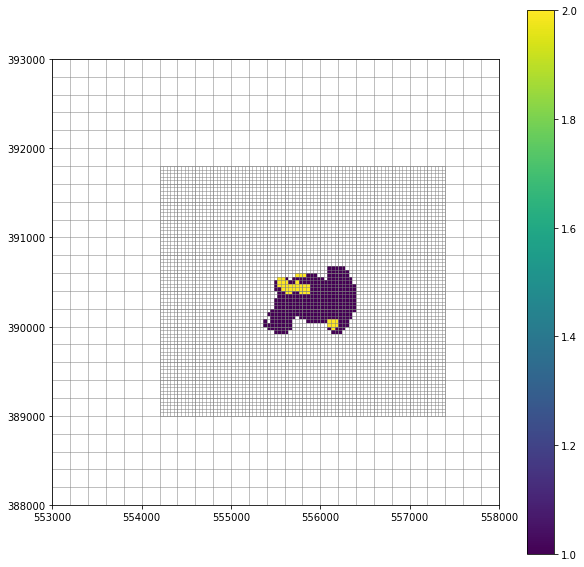

In [13]:
inset = m.inset['plsnt_lgr_inset']

l, r, b, t = m.modelgrid.extent
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

#inset_mv.plot_bc('LAK', color='navy')
#parent_mv.plot_bc('WEL_0', color='red')

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi)

### write the MODFLOW input files
(just like you would for a Flopy model)

In [14]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing mvr package pleasant_lgr.mvr...
  writing package pleasant_lgr.gwfgwf...
  writing model plsnt_lgr_parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package oc...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 240 based on size of stress_period_data
    writing package obs_0...
    writing package sfr_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package obs_1...
  writing model plsnt_lgr_inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    

### Run the model

In [15]:
m.simulation.run_simulation()

FloPy is using the following executable to run the model: /Users/aleaf/Documents/software/modflow_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Aug 01 2021 12:51:08 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to

(True, [])

### Plot the head results

In [16]:
tmr_parent_headsobj = bf.HeadFile('../data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')

# read the head results for the last stress period
kper = 12
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, kper))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, kper))

# Get the water table elevation from the 3D head results
inset_wt = get_water_table(lgr_inset_hds, nodata=1e30)
parent_wt = get_water_table(lgr_parent_hds, nodata=1e30)

# put in the lake level (not included in head output)
lake_results = pd.read_csv('lake1.obs.csv')
stage = lake_results['STAGE'][kper]
inset_wt[inset.lakarr[0] == 1] = stage

#### First combine the parent and inset model head results
(into a single grid at the inset model resolution; for a nicer looking plot)

In [17]:
# make the single grid
l, b, r, t = m.modelgrid.bounds
xi = np.arange(l, r, 40)
yi = np.arange(b, t, 40)[::-1]
Xi, Yi = np.meshgrid(xi, yi)

# make a single set of points
# including both parent and inset cell centers
# and water table values
x = m.modelgrid.xcellcenters[~parent_wt.mask]
y = m.modelgrid.ycellcenters[~parent_wt.mask]
x = np.append(x, inset.modelgrid.xcellcenters[~inset_wt.mask])
y = np.append(y, inset.modelgrid.ycellcenters[~inset_wt.mask])
z = parent_wt[~parent_wt.mask].data
z = np.append(z, inset_wt[~inset_wt.mask].data)

# interpolate the results from the points
# onto the single inset resolution grid
results = griddata((x, y), z, (Xi, Yi))

### Make the plot
* include the parent and inset model grids
* show the head contours for the combined parent/inset simulation
* show SFR boundary condition cells in green
* show the lakebed leakance zones

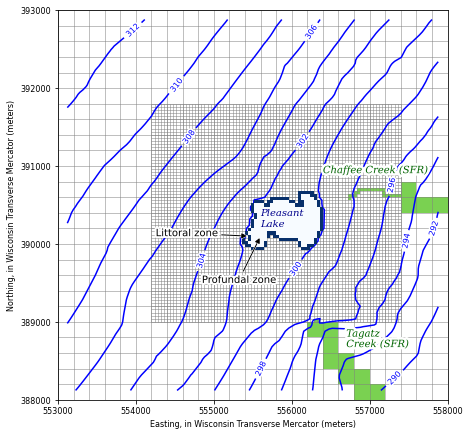

In [18]:
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

layer = 0
fig, ax = plt.subplots(figsize=(6.5, 6.5))
# create Flopy plot objects
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

# plot boundary condition cells from Modflow-setup array properties
inset_bcs = np.ma.masked_array(inset._isbc2d, mask=inset._isbc2d==0)
parent_bcs = np.ma.masked_array(m._isbc2d, mask=m._isbc2d==0)
parent_mv.plot_array(parent_bcs, vmin=0, vmax=5)
inset_mv.plot_array(inset_bcs, vmin=0, vmax=5)

#bdlknc_values = inset.lak.connectiondata.array['bedleak']
conn = inset.lak.connectiondata.array
k, i, j = cellids_to_kij(conn['cellid'])
bdlknc = np.zeros((inset.nlay, inset.nrow, inset.ncol))
bdlknc[k, i, j] = conn['bedleak']
bdlknc = np.max(bdlknc, axis=0)
bdlknc = np.ma.masked_array(bdlknc, mask=bdlknc == 0)
inset_mv.plot_array(bdlknc, cmap='Blues', zorder=200)

# contour the combined inset/parent head results
levels = np.arange(290, 315, 2)
ctr = ax.contour(Xi, Yi, results, levels=levels, colors='b', zorder=10)
labels = ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=10)
plt.setp(labels, path_effects=[
    patheffects.withStroke(linewidth=3, foreground="w")])

# plot the grid cell edges
lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)

ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
ax.set_ylabel('Northing, in Wisconsin Transverse Mercator (meters)')
ax.set_xlabel('Easting, in Wisconsin Transverse Mercator (meters)')

ax.text(555600, 390450, 'Pleasant\nLake', ha='left', va='top', color='DarkBlue', 
        fontsize=10, fontstyle='italic', family='Serif', zorder=202)
txt = ax.text(556400, 391000, 'Chaffee Creek (SFR)', ha='left', va='top', color='DarkGreen', 
        fontsize=10, fontstyle='italic', family='Serif', zorder=20)
txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(556700, 388900, 'Tagatz\nCreek (SFR)', ha='left', va='top', color='DarkGreen', 
        fontsize=10, fontstyle='italic', family='Serif', zorder=20)
txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])

txt = ax.annotate("Littoral zone",
            xy=(555450, 390100), xycoords='data',
            xytext=(555050,390100), textcoords='data',
                  ha='right',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3", fc='k'),
            path_effects=[patheffects.withStroke(linewidth=4, foreground='w')],
            zorder=203
            )
txt.arrow_patch.set_path_effects([
    patheffects.Stroke(linewidth=2, foreground="w"),
    patheffects.Normal()])

txt = ax.annotate("Profundal zone",
            xy=(555600, 390100), xycoords='data',
            xytext=(555800,389500), textcoords='data',
                  ha='right',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3", fc='k'),
            path_effects=[patheffects.withStroke(linewidth=4, foreground='w')],
            zorder=203
            )
txt.arrow_patch.set_path_effects([
    patheffects.Stroke(linewidth=2, foreground="w"),
    patheffects.Normal()])

plt.tight_layout()
plt.savefig('postproc/pdfs/figure_2.pdf')

### Use [Modflow-export](https://github.com/aleaf/modflow-export) to export the modflow input to PDFs, rasters and shapefiles

In [19]:
for model in m, inset:
    mfexport.export(model, model.modelgrid, output_path=f'postproc/{model.name}/')


dis package...
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay4.tif
top:
wrote postproc/plsnt_lgr_parent/rasters/top.tif
botm:
wrote postproc/plsnt_lgr_parent/rasters/botm_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay4.tif
idomain:
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay4.tif

ic package...
strt:
wrote postproc/plsnt_lgr_parent/rasters/strt_

writing postproc/plsnt_lgr_inset/shps/obs1_stress_period_data.shp... Done


#### Modflow-export can also create a summary table of the model inputs

In [20]:
for model in m, inset:
    mfexport.summarize(model, output_path=f'postproc/{model.name}/')

summarizing plsnt_lgr_parent input...
summarizing plsnt_lgr_inset input...
skipped, not implemented yet
